## Define problem

In [2]:
vmin=1364
vmax=6000 #thresholding 5990

h=25

nz=187; nx=801

dt=0.0025
nt=4000  #10 s

ntr=2000

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,title_colorbar=None,grid=True):
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,extent=extent,aspect='auto')
    cbar=plt.colorbar(location='right')
    cbar=cbar.ax.set_ylabel(title_colorbar)
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

In [4]:
def make_FWDrun(app='FWD',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")

def make_FWIrun(app='FWI',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")

In [5]:
from scipy.ndimage import gaussian_filter


def imshow_overlay(data1,data2,alpha=0.6,data1perc=None,data2perc=None,data1clip=None,data2clip=None,
                   cmap1='seismic',cmap2='gray',
                   extent=None,title=None,grid=True):
    if data1perc==None:
        clipp1=[np.amin(data1),np.amax(data1)]
    else:
        tmp=np.percentile(np.abs(data1),q=data1perc)
        clipp1=[-tmp,tmp]
    if data2perc==None:
        clipp2=[np.amin(data2),np.amax(data2)]
    else:
        tmp=np.percentile(np.abs(data2),q=data2perc)
        clipp2=[-tmp,tmp]
    
    if data1clip!=None: clipp1=data1clip
    if data2clip!=None: clipp2=data2clip
        
    plt.imshow(data1,vmin=clipp1[0],vmax=clipp1[1],            cmap=cmap1,extent=extent,aspect='auto')
    plt.imshow(data2,vmin=clipp2[0],vmax=0        ,alpha=alpha,cmap=cmap2,extent=extent,aspect='auto')
    
    #plt.colorbar(location='right')
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='y', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def hilb_env(data):
    return np.abs(signal.hilbert(data,axis=0))

def normalize(data):
    out=np.zeros_like(data)
    amax=np.nanmax(data,axis=0)
    for i in range(amax.size):
        out[:,i]=data[:,i]/amax[i]
    return out
    
def amp_spec(data,axis=0):
    return np.abs(np.fft.rfft(data,axis=axis))

def smooth(data,sigma=(2,8)):
    return gaussian_filter(data,sigma=sigma)

def lat_avg(data):
    return np.mean(data,axis=1)

In [6]:
x=np.arange(0,nx)*h
z=np.arange(0,nz)*h

zpow=np.power(z,2)
zpow=np.tile(zpow,(nx,1)).T

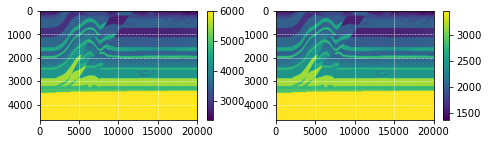

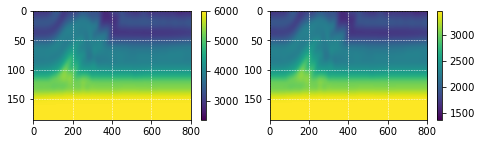

In [7]:
#plot
plt.figure(figsize=(12,2))
true=read('true',(3*nx,nz))
plt.subplot(1,3,1); imshow(true[:,:nx],clip=[2365,6000],extent=(0,(nx-1)*h,(nz-1)*h,0))
plt.subplot(1,3,2); imshow(true[:,nx:2*nx],clip=[1364,3462],extent=(0,(nx-1)*h,(nz-1)*h,0))

plt.figure(figsize=(12,2))
init=read('init',(3*nx,nz))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=[2365,6000])
plt.subplot(1,3,2); imshow(init[:,nx:2*nx],clip=[1364,3462])

In [8]:
#!lda = rho(vp^2-2vs^2)
#!mu  = rho*vs^2
#!rho0= rho
#!gvp = glda*2rho*vp
#!gvs = (glda*-2 + gmu)*2rho*vs
#!grho= glda*vp^2 + (-2glda+gmu)*vs^2 + grho0
vp=init[:,:nx]
vs=init[:,nx:2*nx]
rho=1.
def chain(glda,gmu):
    gvp =  glda            *2*rho*vp
    gvs = (glda*(-2) + gmu)*2*rho*vs
    return (gvp, gvs) 

## Obs

In [9]:
make_FWDrun(resdir='res_obs',tag='obs',np=20,nthreads=1,setup_more=[
]) #elapsed 0.6min for 1shot

bash run_obs.sh
rm: cannot remove 'run_obs.sh': No such file or directory


In [ ]:
plt.figure(figsize=(12,4))
!suwind < results_test21/Ru_Shot0014.su key=trid min=32 max=32 > obs0014.su
imshow(read_su('obs0014.su'),clip=(-1.5e-8,1.5e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < results_test21/Ru_Shot0014.su key=trid min=34 max=34 > obs0014.su
imshow(read_su('obs0014.su'),clip=(-1.5e-8,1.5e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < results_test21/Ru_Shot0014.su key=trid min=22 max=22 > obs0014.su
imshow(read_su('obs0014.su'),clip=(-4e-12,4e-12),title='pz-ex',cmap='gray')

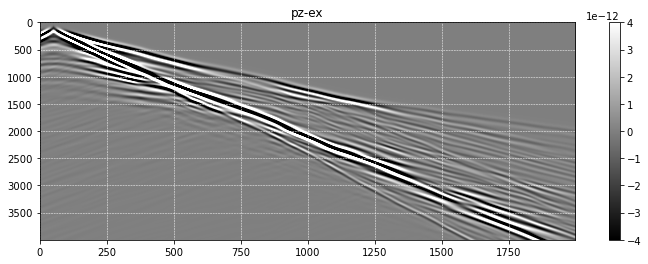

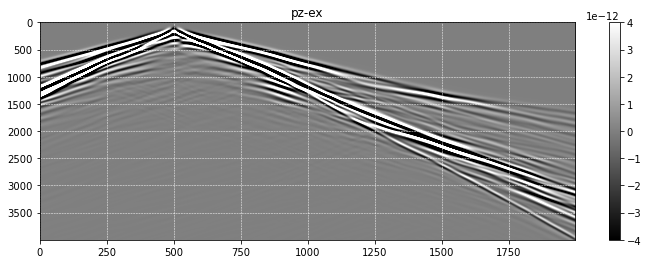

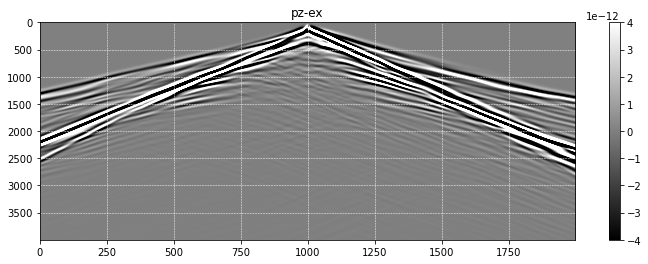

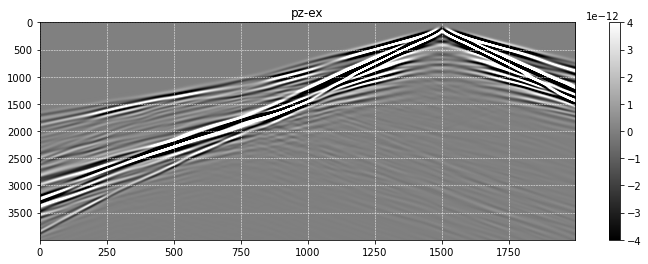

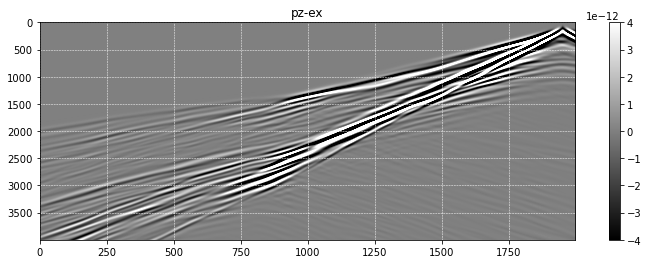

In [6]:
plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=22 max=22 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-4e-12,4e-12),title='pz-ex',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0010.su key=trid min=22 max=22 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-4e-12,4e-12),title='pz-ex',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0020.su key=trid min=22 max=22 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-4e-12,4e-12),title='pz-ex',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0030.su key=trid min=22 max=22 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-4e-12,4e-12),title='pz-ex',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0039.su key=trid min=22 max=22 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-4e-12,4e-12),title='pz-ex',cmap='gray')

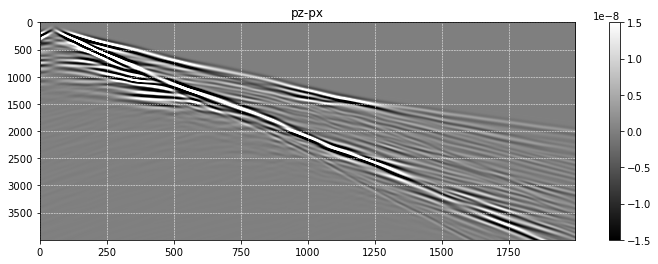

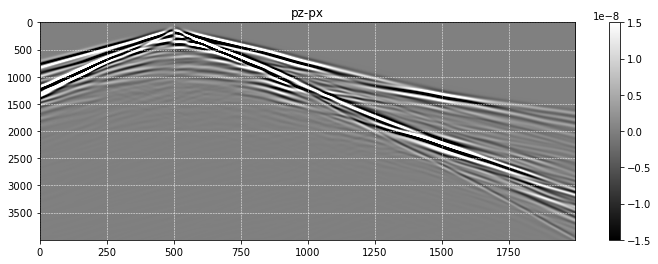

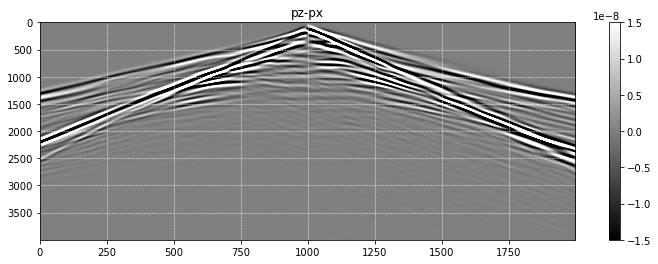

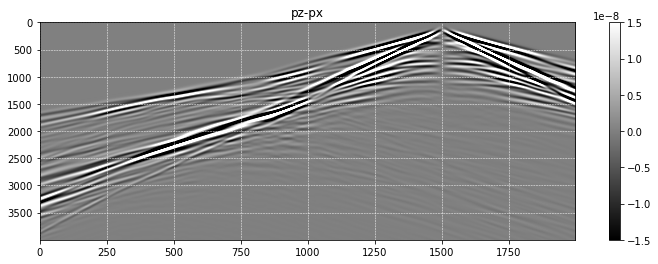

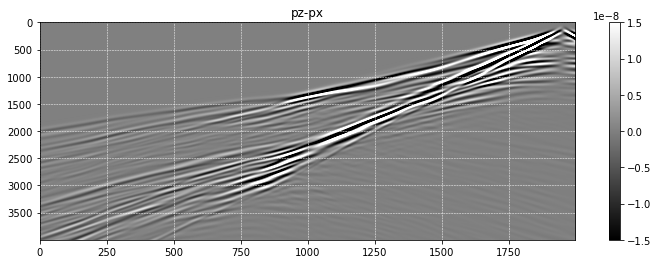

In [10]:
plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=34 max=34 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0010.su key=trid min=34 max=34 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0020.su key=trid min=34 max=34 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0030.su key=trid min=34 max=34 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0039.su key=trid min=34 max=34 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-px',cmap='gray')

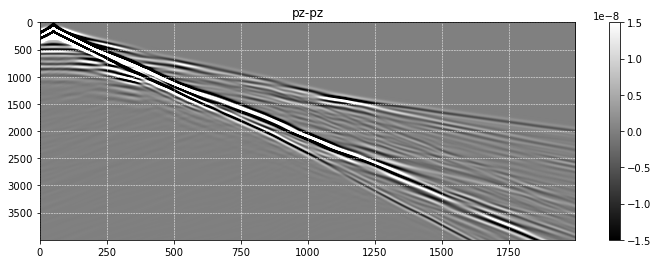

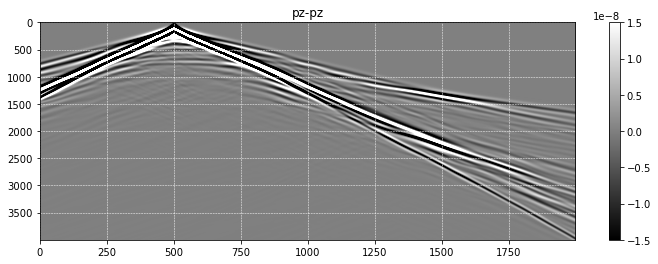

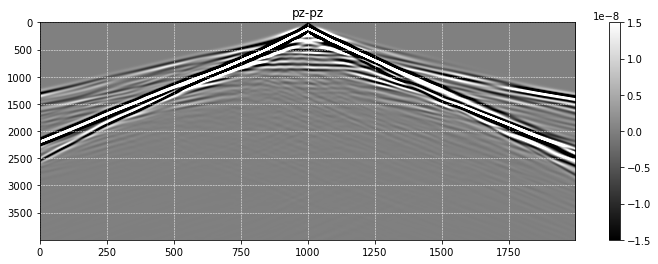

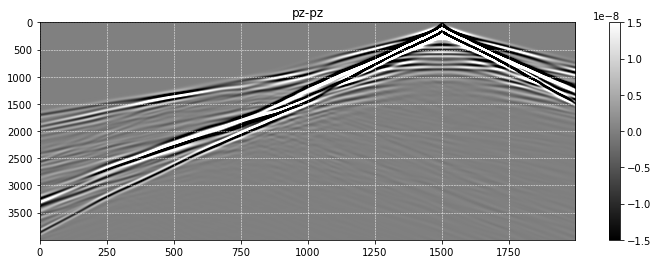

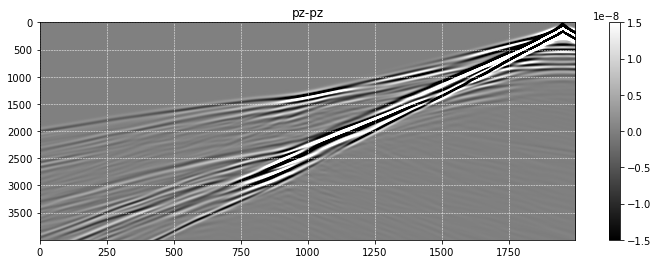

In [8]:
plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=32 max=32 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0010.su key=trid min=32 max=32 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0020.su key=trid min=32 max=32 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0030.su key=trid min=32 max=32 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0039.su key=trid min=32 max=32 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-1.5e-8,1.5e-8),title='pz-pz',cmap='gray')

## full Gradient

In [8]:
#!cd res_obs; for su in `ls Ru_Shot00??.su`; do suwind < $su key=trid min=32 max=32 > pz_$su; done

make_FWIrun(resdir='res_grad_pz-pz',tag='grad',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs/pz_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'"
]) #elapsed 0.6min for forward, 1.3min for adjoint, 1.9min for 1shot

bash run_grad.sh


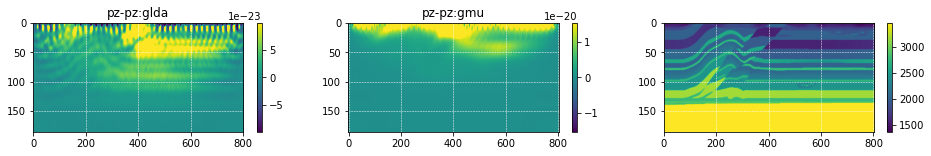

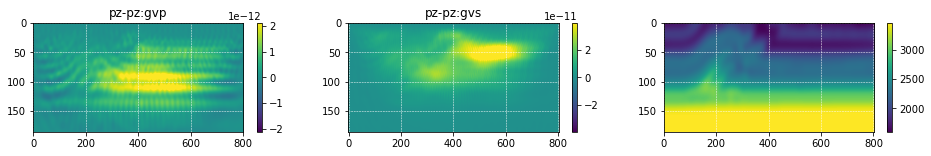

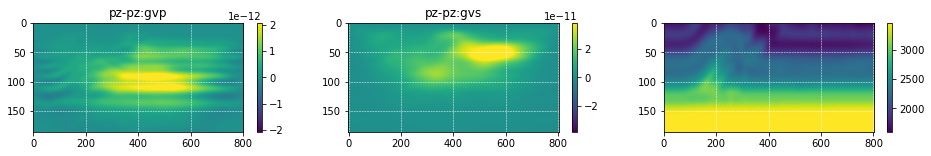

In [9]:
grad=read('res_grad_pz-pz/correlate_gradient',n=(3*nx,nz))

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(grad[:,nx:2*nx],perc=95,title='pz-pz:glda')
plt.subplot(1,3,2); imshow(grad[:,2*nx:],  perc=95,title='pz-pz:gmu')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

gvp,gvs=chain(grad[:,nx:2*nx],grad[:,2*nx:])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(gvp*zpow, perc=98,title='pz-pz:gvp')
plt.subplot(1,3,2); imshow(gvs*zpow, perc=98,title='pz-pz:gvs')
plt.subplot(1,3,3); imshow(init[:,nx:2*nx])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(smooth(gvp,sigma=(2,16))*zpow, perc=98,title='pz-pz:gvp')
plt.subplot(1,3,2); imshow(smooth(gvs,sigma=(2,16))*zpow, perc=98,title='pz-pz:gvs')
plt.subplot(1,3,3); imshow(init[:,nx:2*nx])

In [10]:
#!cd res_obs; for su in `ls Ru_Shot00??.su`; do suwind < $su key=trid min=22 max=22 > ex_$su; done

make_FWIrun(resdir='res_grad_pz-ex',tag='grad',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs/ex_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'"
]) #elapsed 1min for forward, 1.8min for adjoint, 2.8min for 1shot

bash run_grad.sh


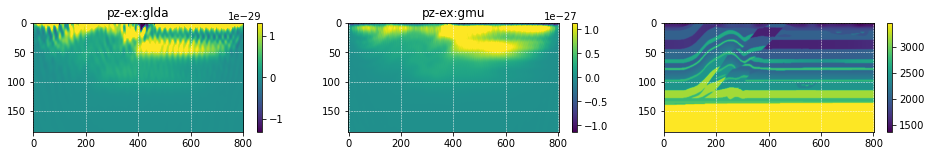

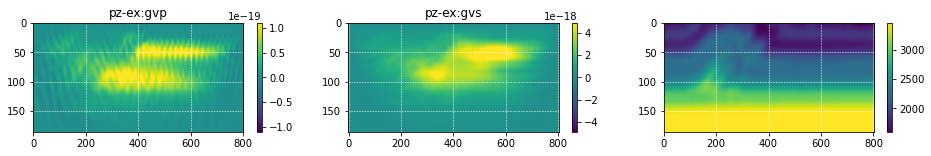

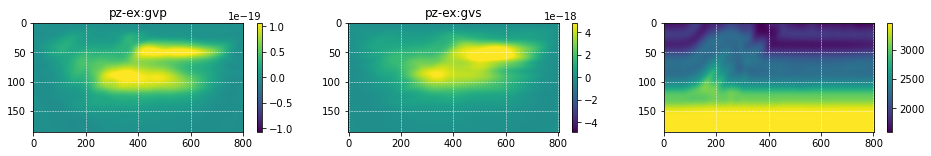

In [11]:
grad=read('res_grad_pz-ex/correlate_gradient',n=(3*nx,nz))

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(grad[:,nx:2*nx],perc=95,title='pz-ex:glda')
plt.subplot(1,3,2); imshow(grad[:,2*nx:],  perc=95,title='pz-ex:gmu')
plt.subplot(1,3,3); imshow(true[:,nx:2*nx])

gvp,gvs=chain(grad[:,nx:2*nx],grad[:,2*nx:])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(gvp*zpow, perc=98,title='pz-ex:gvp')
plt.subplot(1,3,2); imshow(gvs*zpow, perc=98,title='pz-ex:gvs')
plt.subplot(1,3,3); imshow(init[:,nx:2*nx])

plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(smooth(gvp,sigma=(2,16))*zpow, perc=98,title='pz-ex:gvp')
plt.subplot(1,3,2); imshow(smooth(gvs,sigma=(2,16))*zpow, perc=98,title='pz-ex:gvs')
plt.subplot(1,3,3); imshow(init[:,nx:2*nx])